# Setting up Media Pipe

In [ ]:
# Run in first cell
!pip uninstall opencv-python -y
!pip install opencv-python
# THEN RESTART KERNEL

In [ ]:
import sys
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install matplotlib

# THEN RESTART KERNEL

In [ ]:
import cv2
print("OpenCV version:", cv2.__version__)

In [ ]:
!{sys.executable} -m pip install mediapipe
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install imageio


In [ ]:
import sys
print(sys.executable)


In [ ]:
!pip list | findstr opencv

# creating custom display function

In [7]:
def draw_landmarks_on_image(rgb_image, detection_result):
    """
    Draw hand landmarks and connections on an image
    
    Args:
        rgb_image: RGB image as numpy array
        detection_result: HandLandmarkerResult object
    
    Returns:
        Annotated image
    """
    # Create a copy of the image
    annotated_image = np.copy(rgb_image)
    image_height, image_width, _ = annotated_image.shape
    
    # Define hand connections (MediaPipe hand graph)
    HAND_CONNECTIONS = [
        (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
        (0, 5), (5, 6), (6, 7), (7, 8),  # Index finger
        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle finger
        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring finger
        (0, 17), (17, 18), (18, 19), (19, 20),  # Pinky
        (5, 9), (9, 13), (13, 17)  # Palm connections
    ]
    
    # Colors for different parts
    PALM_COLOR = (255, 255, 255)  # White
    THUMB_COLOR = (255, 0, 0)     # Blue
    INDEX_COLOR = (0, 255, 0)     # Green
    MIDDLE_COLOR = (0, 255, 255)  # Yellow
    RING_COLOR = (255, 0, 255)    # Magenta
    PINKY_COLOR = (0, 165, 255)   # Orange
    
    # Function to get color based on landmark index
    def get_connection_color(start_idx, end_idx):
        if start_idx == 0 or end_idx == 0:  # Palm connections
            return PALM_COLOR
        elif 1 <= start_idx <= 4 or 1 <= end_idx <= 4:  # Thumb
            return THUMB_COLOR
        elif 5 <= start_idx <= 8 or 5 <= end_idx <= 8:  # Index finger
            return INDEX_COLOR
        elif 9 <= start_idx <= 12 or 9 <= end_idx <= 12:  # Middle finger
            return MIDDLE_COLOR
        elif 13 <= start_idx <= 16 or 13 <= end_idx <= 16:  # Ring finger
            return RING_COLOR
        elif 17 <= start_idx <= 20 or 17 <= end_idx <= 20:  # Pinky
            return PINKY_COLOR
        return (255, 255, 255)  # Default white
    
    # Draw landmarks and connections for each detected hand
    for hand_idx, hand_landmarks in enumerate(detection_result.hand_landmarks):
        # Draw connections (lines between landmarks)
        for connection in HAND_CONNECTIONS:
            start_idx, end_idx = connection
            
            # Get landmark coordinates
            start_landmark = hand_landmarks[start_idx]
            end_landmark = hand_landmarks[end_idx]
            
            # Convert normalized coordinates to pixel coordinates
            start_x = int(start_landmark.x * image_width)
            start_y = int(start_landmark.y * image_height)
            end_x = int(end_landmark.x * image_width)
            end_y = int(end_landmark.y * image_height)
            
            # Get color for this connection
            connection_color = get_connection_color(start_idx, end_idx)
            
            # Draw the connection line
            cv2.line(annotated_image, (start_x, start_y), (end_x, end_y), 
                    connection_color, 2)
        
        # Draw landmarks (dots at each joint)
        for idx, landmark in enumerate(hand_landmarks):
            x = int(landmark.x * image_width)
            y = int(landmark.y * image_height)
            
            # Different colors/sizes for different landmark types
            if idx == 0:  # Wrist
                cv2.circle(annotated_image, (x, y), 8, (255, 255, 255), -1)  # White
                cv2.circle(annotated_image, (x, y), 8, (0, 0, 0), 1)  # Black border
            elif 1 <= idx <= 4:  # Thumb
                cv2.circle(annotated_image, (x, y), 6, THUMB_COLOR, -1)
            elif 5 <= idx <= 8:  # Index finger
                cv2.circle(annotated_image, (x, y), 6, INDEX_COLOR, -1)
            elif 9 <= idx <= 12:  # Middle finger
                cv2.circle(annotated_image, (x, y), 6, MIDDLE_COLOR, -1)
            elif 13 <= idx <= 16:  # Ring finger
                cv2.circle(annotated_image, (x, y), 6, RING_COLOR, -1)
            elif 17 <= idx <= 20:  # Pinky
                cv2.circle(annotated_image, (x, y), 6, PINKY_COLOR, -1)
        
        # Add handedness text
        if hand_idx < len(detection_result.handedness):
            handedness = detection_result.handedness[hand_idx][0]
            hand_label = handedness.category_name
            confidence = handedness.score
            
            # Position text above the wrist (landmark 0)
            wrist = hand_landmarks[0]
            text_x = int(wrist.x * image_width) - 30
            text_y = int(wrist.y * image_height) - 30
            
            # Choose color based on handedness
            text_color = (0, 0, 255) if hand_label == "Left" else (255, 0, 0)  # Red for Left, Blue for Right
            
            # Draw text
            text = f"{hand_label}: {confidence:.2f}"
            cv2.putText(annotated_image, text, (text_x, text_y),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, text_color, 2)
    
    return annotated_image


# setting up model for image estimation

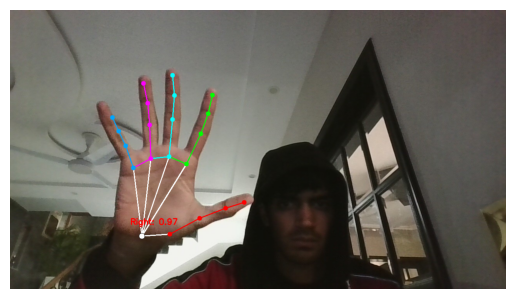

In [8]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path="C:/hammad's_everything/academic/Fall-Spring-Break/HandTrackingFolder/hand_landmarker.task")
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("C:/hammad's_everything/academic/Fall-Spring-Break/HandTrackingFolder/WIN_20260115_13_17_37_Pro.jpg")

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(annotated_image)
plt.axis("off")
plt.show()

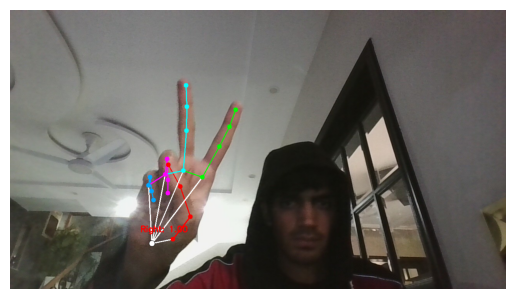

In [9]:
image = mp.Image.create_from_file("C:/hammad's_everything/academic/Fall-Spring-Break/HandTrackingFolder/WIN_20260115_13_17_34_Pro.jpg")

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(annotated_image)
plt.axis("off")
plt.show()

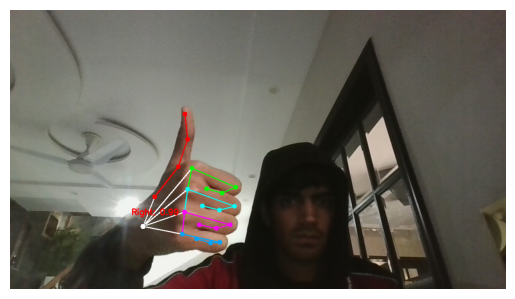

In [10]:
image = mp.Image.create_from_file("C:/hammad's_everything/academic/Fall-Spring-Break/HandTrackingFolder/WIN_20260115_13_17_31_Pro.jpg")

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(annotated_image)
plt.axis("off")
plt.show()

# hand tracking on video

In [27]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

def process_video_file(video_path, model_path='hand_landmarker.task', output_path='output_video.mp4'):
    """
    Process a video file and detect hand landmarks
    
    Args:
        video_path: Path to input video file
        model_path: Path to hand landmarker model
        output_path: Path to save output video
    """
    
    # Create hand landmarker for video mode
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.HandLandmarkerOptions(
        base_options=base_options,
        num_hands=2,
        min_hand_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        running_mode=vision.RunningMode.VIDEO  # IMPORTANT: Set to VIDEO mode
    )
    landmarker = vision.HandLandmarker.create_from_options(options)
    
    # Open video file
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Processing video: {video_path}")
    print(f"Resolution: {width}x{height}, FPS: {fps}, Total frames: {frame_count}")
    
    # Setup video writer for output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    frame_idx = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            break
        
        # Convert BGR to RGB (OpenCV uses BGR, MediaPipe uses RGB)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Convert to MediaPipe Image
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)
        
        # Calculate timestamp in milliseconds
        frame_timestamp_ms = int(frame_idx * (1000 / fps))
        
        # Detect hand landmarks for video
        detection_result = landmarker.detect_for_video(mp_image, frame_timestamp_ms)
        
        # Draw landmarks on frame (using the function from before)
        annotated_frame = draw_hand_landmarks_on_image(rgb_frame, detection_result)
        
        # Convert back to BGR for OpenCV display/saving
        annotated_frame_bgr = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
        
        # Add frame counter
        cv2.putText(annotated_frame_bgr, f"Frame: {frame_idx}/{frame_count}", 
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        # Write frame to output video
        out.write(annotated_frame_bgr)
        
        # Display frame (optional)
        cv2.imshow('Hand Landmarks - Video', annotated_frame_bgr)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        frame_idx += 1
        
        # Progress update
        if frame_idx % 30 == 0:
            print(f"Processed {frame_idx}/{frame_count} frames")
    
    # Release everything
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Video processing complete! Output saved to: {output_path}")

# Function to draw landmarks (same as before)
def draw_hand_landmarks_on_image(rgb_image, detection_result):
    """Draw hand landmarks on image"""
    annotated_image = np.copy(rgb_image)
    image_height, image_width, _ = annotated_image.shape
    
    HAND_CONNECTIONS = [
        (0, 1), (1, 2), (2, 3), (3, 4),
        (0, 5), (5, 6), (6, 7), (7, 8),
        (0, 9), (9, 10), (10, 11), (11, 12),
        (0, 13), (13, 14), (14, 15), (15, 16),
        (0, 17), (17, 18), (18, 19), (19, 20),
        (5, 9), (9, 13), (13, 17)
    ]
    
    # Draw for each hand
    for hand_idx, hand_landmarks in enumerate(detection_result.hand_landmarks):
        # Draw connections
        for connection in HAND_CONNECTIONS:
            start_idx, end_idx = connection
            start_landmark = hand_landmarks[start_idx]
            end_landmark = hand_landmarks[end_idx]
            
            start_x = int(start_landmark.x * image_width)
            start_y = int(start_landmark.y * image_height)
            end_x = int(end_landmark.x * image_width)
            end_y = int(end_landmark.y * image_height)
            
            cv2.line(annotated_image, (start_x, start_y), (end_x, end_y), 
                    (0, 255, 0), 2)
        
        # Draw landmarks
        for landmark in hand_landmarks:
            x = int(landmark.x * image_width)
            y = int(landmark.y * image_height)
            cv2.circle(annotated_image, (x, y), 3, (255, 0, 0), -1)
    
    return annotated_image

# Usage
process_video_file("C:/hammad's_everything/academic/Fall-Spring-Break/HandTrackingFolder/WIN_20260116_22_48_44_Pro.mp4", output_path='hand_landmarks_output.mp4')

Processing video: C:/hammad's_everything/academic/Fall-Spring-Break/HandTrackingFolder/WIN_20260116_22_48_44_Pro.mp4
Resolution: 1280x720, FPS: 15, Total frames: 271
Processed 30/271 frames
Processed 60/271 frames
Processed 90/271 frames
Processed 120/271 frames
Processed 150/271 frames
Processed 180/271 frames
Processed 210/271 frames
Processed 240/271 frames
Processed 270/271 frames
Video processing complete! Output saved to: hand_landmarks_output.mp4


# Hand tracking Live

In [26]:
import cv2
import numpy as np
import mediapipe as mp
import time
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

def process_video_with_gestures(video_path, model_path='gesture_recognizer.task', output_path='gesture_output.mp4'):
    """
    Process a video file and detect gestures
    
    Args:
        video_path: Path to input video file
        model_path: Path to gesture recognizer model
        output_path: Path to save output video
    """
    
    # Create gesture recognizer for video mode
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.GestureRecognizerOptions(
        base_options=base_options,
        num_hands=2,
        min_hand_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        running_mode=vision.RunningMode.VIDEO
    )
    recognizer = vision.GestureRecognizer.create_from_options(options)
    
    # Open video file
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Processing video: {video_path}")
    print(f"Resolution: {width}x{height}, FPS: {fps}, Total frames: {frame_count}")
    
    # Setup video writer for output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    frame_idx = 0
    start_time = time.time()
    
    print("Processing video with gesture recognition...")
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            break
        
        # Convert BGR to RGB (OpenCV uses BGR, MediaPipe uses RGB)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Convert to MediaPipe Image
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)
        
        # Calculate timestamp in milliseconds
        frame_timestamp_ms = int(frame_idx * (1000 / fps))
        
        # Detect gestures for video
        recognition_result = recognizer.recognize_for_video(mp_image, frame_timestamp_ms)
        
        # Draw gesture information on frame
        annotated_frame = draw_gestures_on_image(rgb_frame, recognition_result, frame_idx, frame_count)
        
        # Convert back to BGR for OpenCV display/saving
        annotated_frame_bgr = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
        
        # Write frame to output video
        out.write(annotated_frame_bgr)
        
        # Display frame (optional)
        cv2.imshow('Gesture Recognition - Video', annotated_frame_bgr)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("\nProcessing interrupted by user")
            break
        
        frame_idx += 1
        
        # Progress update
        if frame_idx % 30 == 0:
            elapsed = time.time() - start_time
            frames_per_sec = frame_idx / elapsed if elapsed > 0 else 0
            percent_complete = (frame_idx / frame_count) * 100
            print(f"Processed {frame_idx}/{frame_count} frames ({percent_complete:.1f}%) | {frames_per_sec:.1f} FPS")
    
    # Release everything
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
    elapsed = time.time() - start_time
    print(f"\nVideo processing complete!")
    print(f"Output saved to: {output_path}")
    print(f"Total time: {elapsed:.1f} seconds")
    print(f"Average FPS: {frame_idx/elapsed:.1f}")

def draw_gestures_on_image(rgb_image, recognition_result, frame_idx, total_frames):
    """Draw gesture information on image"""
    annotated_image = np.copy(rgb_image)
    image_height, image_width, _ = annotated_image.shape
    
    # HAND_CONNECTIONS for drawing hand skeleton
    HAND_CONNECTIONS = [
        (0, 1), (1, 2), (2, 3), (3, 4),
        (0, 5), (5, 6), (6, 7), (7, 8),
        (0, 9), (9, 10), (10, 11), (11, 12),
        (0, 13), (13, 14), (14, 15), (15, 16),
        (0, 17), (17, 18), (18, 19), (19, 20),
        (5, 9), (9, 13), (13, 17)
    ]
    
    # Draw hand landmarks and connections
    for hand_idx, hand_landmarks in enumerate(recognition_result.hand_landmarks):
        # Draw connections
        for connection in HAND_CONNECTIONS:
            start_idx, end_idx = connection
            start_landmark = hand_landmarks[start_idx]
            end_landmark = hand_landmarks[end_idx]
            
            start_x = int(start_landmark.x * image_width)
            start_y = int(start_landmark.y * image_height)
            end_x = int(end_landmark.x * image_width)
            end_y = int(end_landmark.y * image_height)
            
            cv2.line(annotated_image, (start_x, start_y), (end_x, end_y), 
                    (0, 255, 0), 2)
        
        # Draw landmarks
        for landmark in hand_landmarks:
            x = int(landmark.x * image_width)
            y = int(landmark.y * image_height)
            cv2.circle(annotated_image, (x, y), 3, (255, 0, 0), -1)
    
    # Draw gesture information
    y_offset = 30
    for hand_idx, gesture_list in enumerate(recognition_result.gestures):
        if gesture_list:
            top_gesture = gesture_list[0]
            gesture_name = top_gesture.category_name
            confidence = top_gesture.score
            
            # Get handedness if available
            handedness = ""
            if hand_idx < len(recognition_result.handedness):
                if recognition_result.handedness[hand_idx]:
                    handedness = recognition_result.handedness[hand_idx][0].category_name
            
            # Choose color based on gesture
            if gesture_name == "Open_Palm":
                text_color = (0, 255, 0)  # Green
            elif gesture_name == "Closed_Fist":
                text_color = (0, 0, 255)  # Red
            elif gesture_name == "Victory" or gesture_name == "Peace":
                text_color = (255, 255, 0)  # Cyan/Yellow
            elif gesture_name == "Thumbs_Up":
                text_color = (255, 165, 0)  # Orange
            elif gesture_name == "Thumbs_Down":
                text_color = (128, 0, 128)  # Purple
            else:
                text_color = (255, 255, 255)  # White
            
            # Display text
            display_text = f"{handedness}: {gesture_name} ({confidence:.2f})"
            cv2.putText(annotated_image, display_text, 
                       (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.7, text_color, 2)
            y_offset += 30
    
    # Add frame counter and info
    cv2.putText(annotated_image, f"Frame: {frame_idx}/{total_frames}", 
               (10, image_height - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    # Add title
    cv2.putText(annotated_image, "Gesture Recognition", 
               (image_width - 250, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    # Add gesture count
    num_gestures = len(recognition_result.gestures)
    cv2.putText(annotated_image, f"Hands detected: {num_gestures}", 
               (image_width - 250, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    
    return annotated_image

# Usage
process_video_with_gestures(
    "C:/hammad's_everything/academic/Fall-Spring-Break/HandTrackingFolder/WIN_20260116_22_48_44_Pro.mp4", 
    output_path='gesture_recognition_output.mp4'
)

Processing video: C:/hammad's_everything/academic/Fall-Spring-Break/HandTrackingFolder/WIN_20260116_22_48_44_Pro.mp4
Resolution: 1280x720, FPS: 15, Total frames: 271
Processing video with gesture recognition...
Processed 30/271 frames (11.1%) | 15.4 FPS
Processed 60/271 frames (22.1%) | 14.4 FPS
Processed 90/271 frames (33.2%) | 14.3 FPS
Processed 120/271 frames (44.3%) | 14.6 FPS
Processed 150/271 frames (55.4%) | 14.3 FPS
Processed 180/271 frames (66.4%) | 14.0 FPS
Processed 210/271 frames (77.5%) | 14.2 FPS
Processed 240/271 frames (88.6%) | 14.3 FPS
Processed 270/271 frames (99.6%) | 14.4 FPS

Video processing complete!
Output saved to: gesture_recognition_output.mp4
Total time: 18.9 seconds
Average FPS: 14.3


In [ ]:

import sys
!{sys.executable} -m pip install pyautogui

# Mouse Control (final)

In [11]:
# ============================================
# HAND GESTURE MOUSE CONTROL - ENHANCED SMOOTHING
# ============================================
import cv2
import mediapipe as mp
import pyautogui
import time
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
from collections import deque

# Setup gesture recognizer
gesture_model_path = "gesture_recognizer.task"
gesture_base_options = python.BaseOptions(model_asset_path=gesture_model_path)
gesture_options = vision.GestureRecognizerOptions(
    base_options=gesture_base_options,
    num_hands=2,
    min_hand_detection_confidence=0.6,
    min_tracking_confidence=0.5,
    running_mode=vision.RunningMode.IMAGE
)
gesture_recognizer = vision.GestureRecognizer.create_from_options(gesture_options)

screen_w, screen_h = pyautogui.size()
pyautogui.FAILSAFE = False
pyautogui.PAUSE = 0

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# ===== ENHANCED SMOOTHING CLASS =====
class SmoothCursor:
    def __init__(self, buffer_size=7, alpha=0.15, velocity_threshold=5):
        """
        buffer_size: Number of positions to average (higher = smoother but more lag)
        alpha: Exponential smoothing factor (lower = smoother but slower response)
        velocity_threshold: Minimum movement in pixels to update cursor (reduces jitter)
        """
        self.buffer_size = buffer_size
        self.alpha = alpha
        self.velocity_threshold = velocity_threshold
        
        # Use deque for efficient buffer management
        self.pos_buffer_x = deque(maxlen=buffer_size)
        self.pos_buffer_y = deque(maxlen=buffer_size)
        
        # Exponentially weighted moving average
        self.ema_x = None
        self.ema_y = None
        
        # Kalman-like filtering
        self.predicted_x = None
        self.predicted_y = None
        self.velocity_x = 0
        self.velocity_y = 0
        
        # Previous position for velocity calculation
        self.prev_raw_x = None
        self.prev_raw_y = None
        
    def update(self, raw_x, raw_y):
        """Process new position and return smoothed coordinates"""
        
        # Add to buffer
        self.pos_buffer_x.append(raw_x)
        self.pos_buffer_y.append(raw_y)
        
        # Calculate moving average
        avg_x = sum(self.pos_buffer_x) / len(self.pos_buffer_x)
        avg_y = sum(self.pos_buffer_y) / len(self.pos_buffer_y)
        
        # Initialize EMA on first run
        if self.ema_x is None:
            self.ema_x = avg_x
            self.ema_y = avg_y
            self.predicted_x = avg_x
            self.predicted_y = avg_y
            self.prev_raw_x = raw_x
            self.prev_raw_y = raw_y
            return int(avg_x), int(avg_y)
        
        # Calculate velocity from raw positions
        if self.prev_raw_x is not None:
            vel_x = raw_x - self.prev_raw_x
            vel_y = raw_y - self.prev_raw_y
            
            # Smooth velocity
            self.velocity_x = self.velocity_x * 0.7 + vel_x * 0.3
            self.velocity_y = self.velocity_y * 0.7 + vel_y * 0.3
        
        self.prev_raw_x = raw_x
        self.prev_raw_y = raw_y
        
        # Exponential moving average
        self.ema_x = self.ema_x * (1 - self.alpha) + avg_x * self.alpha
        self.ema_y = self.ema_y * (1 - self.alpha) + avg_y * self.alpha
        
        # Prediction with velocity (helps with responsiveness)
        self.predicted_x = self.ema_x + self.velocity_x * 0.5
        self.predicted_y = self.ema_y + self.velocity_y * 0.5
        
        # Apply velocity threshold to reduce micro-jitter
        final_x = self.predicted_x
        final_y = self.predicted_y
        
        return int(final_x), int(final_y)
    
    def reset(self):
        """Reset all buffers and state"""
        self.pos_buffer_x.clear()
        self.pos_buffer_y.clear()
        self.ema_x = None
        self.ema_y = None
        self.predicted_x = None
        self.predicted_y = None
        self.velocity_x = 0
        self.velocity_y = 0
        self.prev_raw_x = None
        self.prev_raw_y = None

# ===== STATE PERSISTENCE CLASS WITH RIGHT CLICK =====
class ClickState:
    def __init__(self):
        self.left_click_active = False
        self.right_click_active = False
        self.last_known_gesture = None
        self.last_gesture_time = 0
        self.gesture_timeout = 0.5
        self.grace_period = 0.3
        self.click_cooldown = 0.2
        
    def update(self, current_gesture, confidence=1.0):
        """Update state and return actions needed"""
        current_time = time.time()
        actions = []
        
        if current_gesture and confidence > 0.5:
            self.last_known_gesture = current_gesture
            self.last_gesture_time = current_time
        
        if not current_gesture:
            time_since_last_gesture = current_time - self.last_gesture_time
            if time_since_last_gesture < self.gesture_timeout:
                current_gesture = self.last_known_gesture
        
        if current_gesture == "Closed_Fist":
            if not self.left_click_active:
                if self.right_click_active:
                    actions.append(("release_right_click", None))
                    self.right_click_active = False
                actions.append(("start_left_click", None))
                self.left_click_active = True
                
        elif current_gesture == "Victory" or current_gesture == "Peace":
            if not self.right_click_active:
                if self.left_click_active:
                    actions.append(("release_left_click", None))
                    self.left_click_active = False
                actions.append(("start_right_click", None))
                self.right_click_active = True
                
        else:
            if self.left_click_active:
                if current_gesture and current_gesture != "Closed_Fist":
                    actions.append(("release_left_click", None))
                    self.left_click_active = False
                elif not current_gesture and (current_time - self.last_gesture_time > self.grace_period):
                    actions.append(("release_left_click", None))
                    self.left_click_active = False
            
            if self.right_click_active:
                if current_gesture and current_gesture not in ["Victory", "Peace"]:
                    actions.append(("release_right_click", None))
                    self.right_click_active = False
                elif not current_gesture and (current_time - self.last_gesture_time > self.grace_period):
                    actions.append(("release_right_click", None))
                    self.right_click_active = False
        
        return actions, current_gesture

# Initialize components
click_state = ClickState()
smooth_cursor = SmoothCursor(buffer_size=7, alpha=0.2, velocity_threshold=3)

# Screen edge margins
margin_left = 0.05
margin_right = 0.05
margin_top = 0.05
margin_bottom = 0.05

print("=" * 60)
print("HAND GESTURE MOUSE CONTROL - ULTRA SMOOTH TRACKING")
print("=" * 60)
print("LEFT HAND:")
print("  • Index finger → Move cursor (ULTRA SMOOTH)")
print("")
print("RIGHT HAND:")
print("  • Closed_Fist → Left click and hold")
print("  • Victory/Peace sign → Right click")
print("  • Open_Palm → Release click")
print("")
print("Press 'q' to quit")
print("=" * 60)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb)
    result = gesture_recognizer.recognize(mp_image)
    
    left_hand_landmarks = None
    right_hand_landmarks = None
    right_hand_gesture = None
    right_hand_confidence = 0
    
    if result.hand_landmarks and result.handedness and result.gestures:
        for i, handedness in enumerate(result.handedness):
            if not handedness:
                continue
                
            hand_label = handedness[0].category_name
            
            if hand_label == "Left":
                left_hand_landmarks = result.hand_landmarks[i]
            elif hand_label == "Right":
                right_hand_landmarks = result.hand_landmarks[i]
                if result.gestures[i] and len(result.gestures[i]) > 0:
                    right_hand_gesture = result.gestures[i][0].category_name
                    right_hand_confidence = result.gestures[i][0].score
    
    # ===== ULTRA SMOOTH CURSOR MOVEMENT =====
    if left_hand_landmarks and len(left_hand_landmarks) > 8:
        hand_x = left_hand_landmarks[8].x
        hand_y = left_hand_landmarks[8].y
        
        # Apply margin scaling
        scaled_x = (hand_x - margin_left) / (1 - margin_left - margin_right)
        scaled_y = (hand_y - margin_top) / (1 - margin_top - margin_bottom)
        
        # Clamp
        scaled_x = max(0, min(1, scaled_x))
        scaled_y = max(0, min(1, scaled_y))
        
        # Convert to screen coordinates
        raw_x = int(scaled_x * screen_w)
        raw_y = int(scaled_y * screen_h)
        
        # Apply advanced smoothing
        smooth_x, smooth_y = smooth_cursor.update(raw_x, raw_y)
        
        # Clamp final position to screen bounds
        smooth_x = max(0, min(smooth_x, screen_w - 1))
        smooth_y = max(0, min(smooth_y, screen_h - 1))
        
        # Move cursor
        pyautogui.moveTo(smooth_x, smooth_y, _pause=False)
        
        # Draw cursor indicator
        h, w, _ = frame.shape
        lx = int(left_hand_landmarks[8].x * w)
        ly = int(left_hand_landmarks[8].y * h)
        cv2.circle(frame, (lx, ly), 10, (0, 255, 0), 2)
        cv2.putText(frame, "CURSOR", (lx + 15, ly), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    else:
        # Reset smoothing when hand is not detected
        smooth_cursor.reset()
    
    # ===== RIGHT HAND: CLICK CONTROL =====
    actions, effective_gesture = click_state.update(right_hand_gesture, right_hand_confidence)
    
    for action, _ in actions:
        if action == "start_left_click":
            pyautogui.mouseDown(button='left')
            print(f"✓ LEFT CLICK STARTED")
        elif action == "release_left_click":
            pyautogui.mouseUp(button='left')
            print(f"✓ LEFT CLICK RELEASED")
        elif action == "start_right_click":
            pyautogui.mouseDown(button='right')
            print(f"✓ RIGHT CLICK STARTED")
        elif action == "release_right_click":
            pyautogui.mouseUp(button='right')
            print(f"✓ RIGHT CLICK RELEASED")
    
    # ===== VISUAL FEEDBACK =====
    cv2.rectangle(frame, (5, 5), (500, 140), (0, 0, 0), -1)
    
    if click_state.left_click_active:
        status_text = "LEFT CLICK ACTIVE"
        status_color = (0, 0, 255)
    elif click_state.right_click_active:
        status_text = "RIGHT CLICK ACTIVE"
        status_color = (0, 255, 255)
    else:
        status_text = "READY"
        status_color = (0, 255, 0)
    
    cv2.putText(frame, status_text, (10, 35),
               cv2.FONT_HERSHEY_SIMPLEX, 1.2, status_color, 3)
    
    if right_hand_gesture:
        gesture_display = f"Gesture: {right_hand_gesture} ({right_hand_confidence:.2f})"
        gesture_color = (255, 255, 255)
    elif effective_gesture:
        gesture_display = f"Persisted: {effective_gesture}"
        gesture_color = (255, 165, 0)
    else:
        gesture_display = "No gesture detected"
        gesture_color = (100, 100, 100)
    
    cv2.putText(frame, gesture_display, (10, 65),
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, gesture_color, 2)
    
    cv2.putText(frame, "Fist=Left Click | Peace=Right Click | Palm=Release", (10, 95),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    
    cv2.putText(frame, "Move cursor with left index finger (ULTRA SMOOTH)", (10, 120),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)
    
    # Right hand visual feedback
    if right_hand_landmarks:
        h, w, _ = frame.shape
        if len(right_hand_landmarks) > 9:
            rx = int(right_hand_landmarks[9].x * w)
            ry = int(right_hand_landmarks[9].y * h)
            
            if click_state.left_click_active:
                cv2.circle(frame, (rx, ry), 20, (0, 0, 255), -1)
                hand_text = "LEFT CLICK"
                text_color = (255, 255, 255)
            elif click_state.right_click_active:
                cv2.circle(frame, (rx, ry), 20, (0, 255, 255), -1)
                hand_text = "RIGHT CLICK"
                text_color = (0, 0, 0)
            elif right_hand_gesture == "Closed_Fist":
                cv2.circle(frame, (rx, ry), 15, (0, 0, 255), 2)
                hand_text = "FIST"
                text_color = (0, 0, 255)
            elif right_hand_gesture in ["Victory", "Peace"]:
                cv2.circle(frame, (rx, ry), 15, (0, 255, 255), 2)
                hand_text = "PEACE"
                text_color = (0, 255, 255)
            else:
                cv2.circle(frame, (rx, ry), 15, (255, 255, 255), 2)
                hand_text = right_hand_gesture if right_hand_gesture else "OPEN"
                text_color = (255, 255, 255)
            
            cv2.putText(frame, hand_text, (rx + 25, ry), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)
    
    cv2.imshow('Hand Control - Ultra Smooth', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        if click_state.left_click_active:
            pyautogui.mouseUp(button='left')
        if click_state.right_click_active:
            pyautogui.mouseUp(button='right')
        break

cap.release()
cv2.destroyAllWindows()
print("\nProgram ended")

HAND GESTURE MOUSE CONTROL - ULTRA SMOOTH TRACKING
LEFT HAND:
  • Index finger → Move cursor (ULTRA SMOOTH)

RIGHT HAND:
  • Closed_Fist → Left click and hold
  • Victory/Peace sign → Right click
  • Open_Palm → Release click

Press 'q' to quit

Program ended


complete with scroll up and down 

In [ ]:
# ============================================
# HAND GESTURE MOUSE CONTROL - ENHANCED SMOOTHING
# ============================================
import cv2
import mediapipe as mp
import pyautogui
import time
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
from collections import deque

# Setup gesture recognizer
gesture_model_path = "gesture_recognizer.task"
gesture_base_options = python.BaseOptions(model_asset_path=gesture_model_path)
gesture_options = vision.GestureRecognizerOptions(
    base_options=gesture_base_options,
    num_hands=2,
    min_hand_detection_confidence=0.6,
    min_tracking_confidence=0.5,
    running_mode=vision.RunningMode.IMAGE
)
gesture_recognizer = vision.GestureRecognizer.create_from_options(gesture_options)

screen_w, screen_h = pyautogui.size()
pyautogui.FAILSAFE = False
pyautogui.PAUSE = 0

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# ===== ENHANCED SMOOTHING CLASS =====
class SmoothCursor:
    def __init__(self, buffer_size=7, alpha=0.15, velocity_threshold=5):
        """
        buffer_size: Number of positions to average (higher = smoother but more lag)
        alpha: Exponential smoothing factor (lower = smoother but slower response)
        velocity_threshold: Minimum movement in pixels to update cursor (reduces jitter)
        """
        self.buffer_size = buffer_size
        self.alpha = alpha
        self.velocity_threshold = velocity_threshold
        
        # Use deque for efficient buffer management
        self.pos_buffer_x = deque(maxlen=buffer_size)
        self.pos_buffer_y = deque(maxlen=buffer_size)
        
        # Exponentially weighted moving average
        self.ema_x = None
        self.ema_y = None
        
        # Kalman-like filtering
        self.predicted_x = None
        self.predicted_y = None
        self.velocity_x = 0
        self.velocity_y = 0
        
        # Previous position for velocity calculation
        self.prev_raw_x = None
        self.prev_raw_y = None
        
    def update(self, raw_x, raw_y):
        """Process new position and return smoothed coordinates"""
        
        # Add to buffer
        self.pos_buffer_x.append(raw_x)
        self.pos_buffer_y.append(raw_y)
        
        # Calculate moving average
        avg_x = sum(self.pos_buffer_x) / len(self.pos_buffer_x)
        avg_y = sum(self.pos_buffer_y) / len(self.pos_buffer_y)
        
        # Initialize EMA on first run
        if self.ema_x is None:
            self.ema_x = avg_x
            self.ema_y = avg_y
            self.predicted_x = avg_x
            self.predicted_y = avg_y
            self.prev_raw_x = raw_x
            self.prev_raw_y = raw_y
            return int(avg_x), int(avg_y)
        
        # Calculate velocity from raw positions
        if self.prev_raw_x is not None:
            vel_x = raw_x - self.prev_raw_x
            vel_y = raw_y - self.prev_raw_y
            
            # Smooth velocity
            self.velocity_x = self.velocity_x * 0.7 + vel_x * 0.3
            self.velocity_y = self.velocity_y * 0.7 + vel_y * 0.3
        
        self.prev_raw_x = raw_x
        self.prev_raw_y = raw_y
        
        # Exponential moving average
        self.ema_x = self.ema_x * (1 - self.alpha) + avg_x * self.alpha
        self.ema_y = self.ema_y * (1 - self.alpha) + avg_y * self.alpha
        
        # Prediction with velocity (helps with responsiveness)
        self.predicted_x = self.ema_x + self.velocity_x * 0.5
        self.predicted_y = self.ema_y + self.velocity_y * 0.5
        
        # Apply velocity threshold to reduce micro-jitter
        final_x = self.predicted_x
        final_y = self.predicted_y
        
        return int(final_x), int(final_y)
    
    def reset(self):
        """Reset all buffers and state"""
        self.pos_buffer_x.clear()
        self.pos_buffer_y.clear()
        self.ema_x = None
        self.ema_y = None
        self.predicted_x = None
        self.predicted_y = None
        self.velocity_x = 0
        self.velocity_y = 0
        self.prev_raw_x = None
        self.prev_raw_y = None

# ===== STATE PERSISTENCE CLASS WITH RIGHT CLICK AND SCROLLING =====
class ClickState:
    def __init__(self):
        self.left_click_active = False
        self.right_click_active = False
        self.scroll_up_active = False
        self.scroll_down_active = False
        self.last_known_gesture = None
        self.last_gesture_time = 0
        self.gesture_timeout = 0.5
        self.grace_period = 0.3
        self.click_cooldown = 0.2
        self.scroll_speed = 15  
        self.last_scroll_time = 0
        self.scroll_interval = 0.05  
        
    def update(self, current_gesture, confidence=1.0):
        """Update state and return actions needed"""
        current_time = time.time()
        actions = []
        
        if current_gesture and confidence > 0.5:
            self.last_known_gesture = current_gesture
            self.last_gesture_time = current_time
        
        if not current_gesture:
            time_since_last_gesture = current_time - self.last_gesture_time
            if time_since_last_gesture < self.gesture_timeout:
                current_gesture = self.last_known_gesture
        
        # Handle scrolling gestures first (thumbs up/down)
        if current_gesture == "Thumb_Up":
            # Scroll UP
            if not self.scroll_up_active:
                # Release any active clicks or scroll down
                if self.left_click_active:
                    actions.append(("release_left_click", None))
                    self.left_click_active = False
                if self.right_click_active:
                    actions.append(("release_right_click", None))
                    self.right_click_active = False
                if self.scroll_down_active:
                    self.scroll_down_active = False
                
                self.scroll_up_active = True
            
            # Perform scroll action if enough time has passed
            if current_time - self.last_scroll_time >= self.scroll_interval:
                actions.append(("scroll_up", self.scroll_speed))
                self.last_scroll_time = current_time
                
        elif current_gesture == "Thumb_Down":
            # Scroll DOWN
            if not self.scroll_down_active:
                # Release any active clicks or scroll up
                if self.left_click_active:
                    actions.append(("release_left_click", None))
                    self.left_click_active = False
                if self.right_click_active:
                    actions.append(("release_right_click", None))
                    self.right_click_active = False
                if self.scroll_up_active:
                    self.scroll_up_active = False
                
                self.scroll_down_active = True
            
            # Perform scroll action if enough time has passed
            if current_time - self.last_scroll_time >= self.scroll_interval:
                actions.append(("scroll_down", self.scroll_speed))
                self.last_scroll_time = current_time
                
        elif current_gesture == "Closed_Fist":
            # LEFT CLICK
            # Stop scrolling if active
            if self.scroll_up_active or self.scroll_down_active:
                self.scroll_up_active = False
                self.scroll_down_active = False
            
            if not self.left_click_active:
                if self.right_click_active:
                    actions.append(("release_right_click", None))
                    self.right_click_active = False
                actions.append(("start_left_click", None))
                self.left_click_active = True
                
        elif current_gesture == "Victory" or current_gesture == "Peace":
            # RIGHT CLICK
            # Stop scrolling if active
            if self.scroll_up_active or self.scroll_down_active:
                self.scroll_up_active = False
                self.scroll_down_active = False
            
            if not self.right_click_active:
                if self.left_click_active:
                    actions.append(("release_left_click", None))
                    self.left_click_active = False
                actions.append(("start_right_click", None))
                self.right_click_active = True
                
        else:
            # Not a recognized gesture - release everything
            if self.left_click_active:
                if current_gesture and current_gesture != "Closed_Fist":
                    actions.append(("release_left_click", None))
                    self.left_click_active = False
                elif not current_gesture and (current_time - self.last_gesture_time > self.grace_period):
                    actions.append(("release_left_click", None))
                    self.left_click_active = False
            
            if self.right_click_active:
                if current_gesture and current_gesture not in ["Victory", "Peace"]:
                    actions.append(("release_right_click", None))
                    self.right_click_active = False
                elif not current_gesture and (current_time - self.last_gesture_time > self.grace_period):
                    actions.append(("release_right_click", None))
                    self.right_click_active = False
            
            # Stop scrolling
            if self.scroll_up_active or self.scroll_down_active:
                self.scroll_up_active = False
                self.scroll_down_active = False
        
        return actions, current_gesture

# Initialize components
click_state = ClickState()
smooth_cursor = SmoothCursor(buffer_size=7, alpha=0.2, velocity_threshold=3)

# Screen edge margins
margin_left = 0.1
margin_right = 0.1
margin_top = 0.1
margin_bottom = 0.1

print("=" * 60)
print("HAND GESTURE MOUSE CONTROL - ULTRA SMOOTH TRACKING")
print("=" * 60)
print("LEFT HAND:")
print("  • Index finger → Move cursor (ULTRA SMOOTH)")
print("")
print("RIGHT HAND:")
print("  • Closed_Fist → Left click and hold")
print("  • Victory/Peace sign → Right click")
print("  • Thumb_Up → Scroll UP (slow)")
print("  • Thumb_Down → Scroll DOWN (slow)")
print("  • Open_Palm → Release click/stop scroll")
print("")
print("Press 'q' to quit")
print("=" * 60)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb)
    result = gesture_recognizer.recognize(mp_image)
    
    left_hand_landmarks = None
    right_hand_landmarks = None
    right_hand_gesture = None
    right_hand_confidence = 0
    
    if result.hand_landmarks and result.handedness and result.gestures:
        for i, handedness in enumerate(result.handedness):
            if not handedness:
                continue
                
            hand_label = handedness[0].category_name
            
            if hand_label == "Left":
                left_hand_landmarks = result.hand_landmarks[i]
            elif hand_label == "Right":
                right_hand_landmarks = result.hand_landmarks[i]
                if result.gestures[i] and len(result.gestures[i]) > 0:
                    right_hand_gesture = result.gestures[i][0].category_name
                    right_hand_confidence = result.gestures[i][0].score
    
    # ===== ULTRA SMOOTH CURSOR MOVEMENT =====
    if left_hand_landmarks and len(left_hand_landmarks) > 8:
        hand_x = left_hand_landmarks[8].x
        hand_y = left_hand_landmarks[8].y
        
        # Apply margin scaling
        scaled_x = (hand_x - margin_left) / (1 - margin_left - margin_right)
        scaled_y = (hand_y - margin_top) / (1 - margin_top - margin_bottom)
        
        # Clamp
        scaled_x = max(0, min(1, scaled_x))
        scaled_y = max(0, min(1, scaled_y))
        
        # Convert to screen coordinates
        raw_x = int(scaled_x * screen_w)
        raw_y = int(scaled_y * screen_h)
        
        # Apply advanced smoothing
        smooth_x, smooth_y = smooth_cursor.update(raw_x, raw_y)
        
        # Clamp final position to screen bounds
        smooth_x = max(0, min(smooth_x, screen_w - 1))
        smooth_y = max(0, min(smooth_y, screen_h - 1))
        
        # Move cursor
        pyautogui.moveTo(smooth_x, smooth_y, _pause=False)
        
        # Draw cursor indicator
        h, w, _ = frame.shape
        lx = int(left_hand_landmarks[8].x * w)
        ly = int(left_hand_landmarks[8].y * h)
        cv2.circle(frame, (lx, ly), 10, (0, 255, 0), 2)
        cv2.putText(frame, "CURSOR", (lx + 15, ly), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    else:
        # Reset smoothing when hand is not detected
        smooth_cursor.reset()
    
    # ===== RIGHT HAND: CLICK AND SCROLL CONTROL =====
    actions, effective_gesture = click_state.update(right_hand_gesture, right_hand_confidence)
    
    for action, param in actions:
        if action == "start_left_click":
            pyautogui.mouseDown(button='left')
            print(f"✓ LEFT CLICK STARTED")
        elif action == "release_left_click":
            pyautogui.mouseUp(button='left')
            print(f"✓ LEFT CLICK RELEASED")
        elif action == "start_right_click":
            pyautogui.mouseDown(button='right')
            print(f"✓ RIGHT CLICK STARTED")
        elif action == "release_right_click":
            pyautogui.mouseUp(button='right')
            print(f"✓ RIGHT CLICK RELEASED")
        elif action == "scroll_up":
            pyautogui.scroll(param)  # Scroll up by scroll_speed
        elif action == "scroll_down":
            pyautogui.scroll(-param)  # Scroll down by scroll_speed
    
    # ===== VISUAL FEEDBACK =====
    cv2.rectangle(frame, (5, 5), (500, 140), (0, 0, 0), -1)
    
    if click_state.left_click_active:
        status_text = "LEFT CLICK ACTIVE"
        status_color = (0, 0, 255)
    elif click_state.right_click_active:
        status_text = "RIGHT CLICK ACTIVE"
        status_color = (0, 255, 255)
    elif click_state.scroll_up_active:
        status_text = "SCROLLING UP"
        status_color = (255, 255, 0)
    elif click_state.scroll_down_active:
        status_text = "SCROLLING DOWN"
        status_color = (255, 128, 0)
    else:
        status_text = "READY"
        status_color = (0, 255, 0)
    
    cv2.putText(frame, status_text, (10, 35),
               cv2.FONT_HERSHEY_SIMPLEX, 1.2, status_color, 3)
    
    if right_hand_gesture:
        gesture_display = f"Gesture: {right_hand_gesture} ({right_hand_confidence:.2f})"
        gesture_color = (255, 255, 255)
    elif effective_gesture:
        gesture_display = f"Persisted: {effective_gesture}"
        gesture_color = (255, 165, 0)
    else:
        gesture_display = "No gesture detected"
        gesture_color = (100, 100, 100)
    
    cv2.putText(frame, gesture_display, (10, 65),
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, gesture_color, 2)
    
    cv2.putText(frame, "Fist=Left | Peace=Right | Thumb Up/Down=Scroll", (10, 95),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    
    cv2.putText(frame, "Move cursor with left index finger (ULTRA SMOOTH)", (10, 120),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)
    
    # Right hand visual feedback
    if right_hand_landmarks:
        h, w, _ = frame.shape
        if len(right_hand_landmarks) > 9:
            rx = int(right_hand_landmarks[9].x * w)
            ry = int(right_hand_landmarks[9].y * h)
            
            if click_state.left_click_active:
                cv2.circle(frame, (rx, ry), 20, (0, 0, 255), -1)
                hand_text = "LEFT CLICK"
                text_color = (255, 255, 255)
            elif click_state.right_click_active:
                cv2.circle(frame, (rx, ry), 20, (0, 255, 255), -1)
                hand_text = "RIGHT CLICK"
                text_color = (0, 0, 0)
            elif click_state.scroll_up_active:
                cv2.circle(frame, (rx, ry), 20, (255, 255, 0), -1)
                hand_text = "SCROLL UP"
                text_color = (0, 0, 0)
            elif click_state.scroll_down_active:
                cv2.circle(frame, (rx, ry), 20, (255, 128, 0), -1)
                hand_text = "SCROLL DOWN"
                text_color = (0, 0, 0)
            elif right_hand_gesture == "Closed_Fist":
                cv2.circle(frame, (rx, ry), 15, (0, 0, 255), 2)
                hand_text = "FIST"
                text_color = (0, 0, 255)
            elif right_hand_gesture in ["Victory", "Peace"]:
                cv2.circle(frame, (rx, ry), 15, (0, 255, 255), 2)
                hand_text = "PEACE"
                text_color = (0, 255, 255)
            elif right_hand_gesture == "Thumb_Up":
                cv2.circle(frame, (rx, ry), 15, (255, 255, 0), 2)
                hand_text = "THUMB UP"
                text_color = (255, 255, 0)
            elif right_hand_gesture == "Thumb_Down":
                cv2.circle(frame, (rx, ry), 15, (255, 128, 0), 2)
                hand_text = "THUMB DOWN"
                text_color = (255, 128, 0)
            else:
                cv2.circle(frame, (rx, ry), 15, (255, 255, 255), 2)
                hand_text = right_hand_gesture if right_hand_gesture else "OPEN"
                text_color = (255, 255, 255)
            
            cv2.putText(frame, hand_text, (rx + 25, ry), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)
    
    cv2.imshow('Hand Control - Ultra Smooth', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        if click_state.left_click_active:
            pyautogui.mouseUp(button='left')
        if click_state.right_click_active:
            pyautogui.mouseUp(button='right')
        break

cap.release()
cv2.destroyAllWindows()
print("\nProgram ended")

HAND GESTURE MOUSE CONTROL - ULTRA SMOOTH TRACKING
LEFT HAND:
  • Index finger → Move cursor (ULTRA SMOOTH)

RIGHT HAND:
  • Closed_Fist → Left click and hold
  • Victory/Peace sign → Right click
  • Thumb_Up → Scroll UP (slow)
  • Thumb_Down → Scroll DOWN (slow)
  • Open_Palm → Release click/stop scroll

Press 'q' to quit
✓ LEFT CLICK STARTED
✓ LEFT CLICK RELEASED
✓ LEFT CLICK STARTED
✓ LEFT CLICK RELEASED
✓ LEFT CLICK STARTED
✓ LEFT CLICK RELEASED
✓ LEFT CLICK STARTED
✓ LEFT CLICK RELEASED
✓ LEFT CLICK STARTED
✓ LEFT CLICK RELEASED
✓ LEFT CLICK STARTED
✓ LEFT CLICK RELEASED
✓ LEFT CLICK STARTED
✓ LEFT CLICK RELEASED
✓ LEFT CLICK STARTED
✓ LEFT CLICK RELEASED
✓ RIGHT CLICK STARTED
✓ RIGHT CLICK RELEASED
✓ LEFT CLICK STARTED
✓ LEFT CLICK RELEASED
✓ LEFT CLICK STARTED
✓ LEFT CLICK RELEASED
✓ LEFT CLICK STARTED
✓ LEFT CLICK RELEASED
✓ RIGHT CLICK STARTED
✓ RIGHT CLICK RELEASED
✓ LEFT CLICK STARTED
✓ LEFT CLICK RELEASED
✓ LEFT CLICK STARTED
✓ LEFT CLICK RELEASED
✓ LEFT CLICK STARTED
✓ LEF